In [1]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
experiments = 5
epochs = 100

activations = ['selu', 'sigmoid']
optimizers = ['Adamax', 'sgd']
colors = ['#000000', '#330000', '#660000', '#990000', '#CC0000', '#FF0000',
          '#003300', '#006600', '#009900', '#00CC00', '#00FF00',
          '#000033', '#000066', '#000099', '#0000CC', '#0000FF',
          '#033000', '#066000', '#099000', '#0CC000', '#0FF000',
          '#000330', '#000660', '#000990', '#000CC0', '#000FF0']
colors_new = ['#FF0000', '#FF8000', '#00AA00', '#0000FF', '#7F00FF', 'k', 'y', 'm', 'c', '#CC0066', '#6600CC', '#066000', '#000000']
colors_opt = ['#FF0000', '#FF8000', '#00AA00', '#0000FF', '#7F00FF', 'k', 'y', 'm', 'c', '#CC0066', '#6600CC', '#066000', '#000000']
lines = ['-', '--', ':', '-.']
cols_f = []
for c in colors:
    for l in lines:
        cols_f.append(c+l)
        
columns=['epoch', 'acc', 'loss', 'val_acc', 'val_loss']

configs = [
    {
        'type': 'no_dropout',
        'rate': 0.0
    },
    {
        'type': 'dropout',
        'rate': 0.2
    },
    {
        'type': 'dropout',
        'rate': 0.35
    },
    {
        'type': 'dropout',
        'rate': 0.5
    },
    {
        'type': 'alpha_dropout',
        'rate': 0.2
    },
    {
        'type': 'alpha_dropout',
        'rate': 0.35
    },
    {
        'type': 'alpha_dropout',
        'rate': 0.5
    },
    {
        'type': 'gaussian_dropout',
        'rate': 0.2
    },
    {
        'type': 'gaussian_dropout',
        'rate': 0.35
    },
    {
        'type': 'gaussian_dropout',
        'rate': 0.5
    },
    {
        'type': 'dropout',
        'rate': 0.1
    },
    {
        'type': 'dropout',
        'rate': 0.7
    },
    {
        'type': 'alpha_dropout',
        'rate': 0.1
    },
    {
        'type': 'alpha_dropout',
        'rate': 0.7
    },
    {
        'type': 'gaussian_dropout',
        'rate': 0.1
    },
    {
        'type': 'gaussian_dropout',
        'rate': 0.7
    },
    {
        'type': 'dropout',
        'rate': 0.1
    },
    {
        'type': 'dropout',
        'rate': 0.7
    },
    {
        'type': 'alpha_dropout',
        'rate': 0.1
    },
    {
        'type': 'alpha_dropout',
        'rate': 0.7
    },
    {
        'type': 'gaussian_dropout',
        'rate': 0.1
    },
    {
        'type': 'gaussian_dropout',
        'rate': 0.7
    },
    {
        'type': 'gaussian_noise',
        'rate': 0.05
    },
    {
        'type': 'gaussian_noise',
        'rate': 0.5
    },
    {
        'type': 'gaussian_noise',
        'rate': 1.0
    }
]


In [3]:
def data_label(prefix):
    if prefix == 'normd':
        return 'Normalized data'
    elif prefix == 'std_sample_wise':
        return 'Standardized data'

def load_data(path, prefix, configs, experiments, activations, optimizers, units):
    data = []
    i = 1
    for act in activations:
        for opt in optimizers:
            for cfg in configs:

                print(' ' * 100, end='\r')
                print('Loading data for combination %d of %d' % (i, len(activations) * len(optimizers) * len(configs)), end='\r')
                
                drp_name = '%s (%s)' % (str(cfg['type']), str(cfg['rate']))
                name = 'Activation: %s, Optimizer: %s, %s, %s' % (act, opt, drp_name, data_label(prefix))
                file_name = '_'.join([prefix, cfg['type'], str(cfg['rate']), act, opt])

                data.append({
                    'name': name,
                    'col': colors[i % len(colors)],
                    'line': lines[i % len(lines)],
                    'act': act,
                    'drp_cfg': drp_name,
                    'opt': opt,
                    'type': cfg['type'],
                    'rate': cfg['rate'],
                    'data_type': prefix,
                    'data' : [pd.read_csv(path + file_name + '_' + str(ex)  + '_' + str(units) + '.csv') for ex in range(experiments)],
                    'max_val_acc':{},

                })

                i+=1
            
    return data

def parse_data(data, epochs, experiments):
    i=1
    for d in range(len(data)):
        
        print(' ' * 100, end='\r')
        print('Parsing data: %d of %d' % (i, len(data)), end='\r')
        
        data[d]['averaged'] = pd.DataFrame(columns=['epoch', 'val_acc'])
        for epoch in range(epochs):
            val_acc = []

            for experiment in range(experiments):
                val_acc.append(data[d]['data'][experiment].iloc[epoch]['val_acc'])

                if epoch == 0:
                    data[d]['max_val_acc'][experiment] = {}
                    data[d]['max_val_acc'][experiment]['val_acc'] = data[d]['data'][experiment].iloc[epoch]['val_acc']
                    data[d]['max_val_acc'][experiment]['epoch'] = epoch
                    data[d]['max_val_acc']['upper_max'] = {}
                    data[d]['max_val_acc']['upper_max']['val_acc'] = data[d]['data'][experiment].iloc[epoch]['val_acc']
                    data[d]['max_val_acc']['upper_max']['epoch'] = epoch
                else:
                    if data[d]['max_val_acc'][experiment]['val_acc'] < data[d]['data'][experiment].iloc[epoch]['val_acc']:
                        data[d]['max_val_acc'][experiment]['val_acc'] = data[d]['data'][experiment].iloc[epoch]['val_acc']
                        data[d]['max_val_acc'][experiment]['epoch'] = epoch
                    if data[d]['data'][experiment].iloc[epoch]['val_acc'] > data[d]['max_val_acc']['upper_max']['val_acc']:
                        data[d]['max_val_acc']['upper_max']['val_acc'] = data[d]['data'][experiment].iloc[epoch]['val_acc']
                        data[d]['max_val_acc']['upper_max']['epoch'] = epoch


            av_val_acc = sum(val_acc)/len(val_acc)

            if epoch == 0:
                data[d]['max_val_acc']['avg'] = {}
                data[d]['max_val_acc']['avg']['val_acc'] = av_val_acc
                data[d]['max_val_acc']['avg']['epoch'] = epoch
            else:
                if(av_val_acc >= data[d]['max_val_acc']['avg']['val_acc']):
                    data[d]['max_val_acc']['avg']['val_acc'] = av_val_acc
                    data[d]['max_val_acc']['avg']['epoch'] = epoch

            data[d]['averaged'] = data[d]['averaged'].append({
                'epoch': epoch,
                'val_acc': av_val_acc
            }, ignore_index=True)
            
        data[d]['max_val_acc']['last_max'] = max([data[d]['data'][experiment]['val_acc'].tolist()[-1] for experiment in range(experiments)])
        
        i+=1
    return data

In [6]:
data_normd = load_data('./training_logs/', 'normd', configs, experiments, activations, optimizers, 64)
data_normd = parse_data(data_normd, epochs, experiments)

In [7]:
check_normd = pd.DataFrame(columns=['config', 'exp', 'acc', 'loss', 'val_acc', 'val_loss', 'opt', 'act', 'data'])
i=0
for d in range(len(data_normd)):
    for experiment in range(experiments):
        check_normd.loc[i] = [data_normd[d]['name'], 
                          experiment,
                          data_normd[d]['data'][experiment]['acc'].tolist()[-1], 
                          data_normd[d]['data'][experiment]['loss'].tolist()[-1], 
                          data_normd[d]['data'][experiment]['val_acc'].tolist()[-1], 
                          data_normd[d]['data'][experiment]['val_loss'].tolist()[-1], 
                          data_normd[d]['opt'], 
                          data_normd[d]['act'],
                          data_normd[d]['data_type']]
        i+=1

check_normd = check_normd.sort_values(by=['val_acc'])
check_normd

,config,exp,acc,loss,val_acc,val_loss,opt,act,data
474,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",4,0.107400,2.303552,0.1010,2.300950,sgd,sigmoid,normd
444,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",4,0.107400,2.303552,0.1010,2.300950,sgd,sigmoid,normd
440,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",0,0.108983,2.304087,0.1135,2.301223,sgd,sigmoid,normd
471,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",1,0.107733,2.303867,0.1135,2.300893,sgd,sigmoid,normd
470,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",0,0.108983,2.304087,0.1135,2.301223,sgd,sigmoid,normd
405,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",0,0.105650,2.303539,0.1135,2.298775,sgd,sigmoid,normd
406,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",1,0.106883,2.303751,0.1135,2.299230,sgd,sigmoid,normd
407,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",2,0.108483,2.303509,0.1135,2.299294,sgd,sigmoid,normd
443,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",3,0.108933,2.304188,0.1135,2.300751,sgd,sigmoid,normd
442,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",2,0.104017,2.304151,0.1135,2.300827,sgd,sigmoid,normd


In [8]:
data_std = load_data('./training_logs/', 'std', configs, experiments, activations, optimizers, 64)
data_std = parse_data(data_std, epochs, experiments)

In [9]:
check_std = pd.DataFrame(columns=['config', 'exp', 'acc', 'loss', 'val_acc', 'val_loss', 'opt', 'act', 'data'])
i=0
for d in range(len(data_std)):
    for experiment in range(experiments):
        check_std.loc[i] = [data_std[d]['name'], 
                          experiment,
                          data_std[d]['data'][experiment]['acc'].tolist()[-1], 
                          data_std[d]['data'][experiment]['loss'].tolist()[-1], 
                          data_std[d]['data'][experiment]['val_acc'].tolist()[-1], 
                          data_std[d]['data'][experiment]['val_loss'].tolist()[-1], 
                          data_std[d]['opt'], 
                          data_std[d]['act'],
                          data_std[d]['data_type']]
        i+=1
check_std = check_std.sort_values(by=['val_acc'])
check_std

,config,exp,acc,loss,val_acc,val_loss,opt,act,data
444,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",4,0.109183,2.303340,0.1135,2.292890,sgd,sigmoid,std
443,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",3,0.108733,2.303427,0.1135,2.293065,sgd,sigmoid,std
472,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",2,0.105767,2.303668,0.1135,2.292663,sgd,sigmoid,std
473,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",3,0.108733,2.303427,0.1135,2.293065,sgd,sigmoid,std
474,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",4,0.109183,2.303340,0.1135,2.292890,sgd,sigmoid,std
442,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",2,0.105767,2.303668,0.1135,2.292663,sgd,sigmoid,std
440,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",0,0.107983,2.303374,0.1148,2.293970,sgd,sigmoid,std
470,"Activation: sigmoid, Optimizer: sgd, alpha_dro...",0,0.107983,2.303374,0.1148,2.293970,sgd,sigmoid,std
315,"Activation: sigmoid, Optimizer: Adamax, alpha_...",0,0.153333,2.147582,0.1921,1.783678,Adamax,sigmoid,std
345,"Activation: sigmoid, Optimizer: Adamax, alpha_...",0,0.153333,2.147582,0.1921,1.783678,Adamax,sigmoid,std


In [10]:
results = pd.DataFrame(columns=[#'Configuration', 
                                'Activation',                            
                                'Optimizer',
                                'Dropout',
                                'Rate',
                                'Data type',
                                'Averaged on Last Epoch', 
                                'Averaged Max Achieved',
                                'Overall Max on Last Epoch',
                                'Overall Max Achieved',
                                'Averaged Max Epoch',
                               ])
j=0
for d in [data_normd, data_std]:
    for i in range(len(d)):
        results.loc[j] = [
            d[i]['act'],
            d[i]['opt'],
            d[i]['type'],
            d[i]['rate'],
            d[i]['data_type'],
            d[i]['averaged']['val_acc'].tolist()[-1] * 100, 
            d[i]['max_val_acc']['avg']['val_acc'] * 100,
            d[i]['max_val_acc']['last_max'] * 100,
            d[i]['max_val_acc']['upper_max']['val_acc'] * 100,
            d[i]['max_val_acc']['avg']['epoch'],

        ]
        j+=1

results_sorted = results.sort_values(by=['Averaged Max Achieved'], ascending = False)
results_sorted.to_csv('./results.csv')
results_sorted

,Activation,Optimizer,Dropout,Rate,Data type,Averaged on Last Epoch,Averaged Max Achieved,Overall Max on Last Epoch,Overall Max Achieved,Averaged Max Epoch
107,selu,Adamax,gaussian_dropout,0.20,std,98.106,98.188,98.31,98.42,97
101,selu,Adamax,dropout,0.20,std,98.136,98.158,98.25,98.31,78
110,selu,Adamax,dropout,0.10,std,98.116,98.136,98.18,98.32,86
116,selu,Adamax,dropout,0.10,std,98.116,98.136,98.18,98.32,86
20,selu,Adamax,gaussian_dropout,0.10,normd,98.090,98.090,98.17,98.18,99
14,selu,Adamax,gaussian_dropout,0.10,normd,98.090,98.090,98.17,98.18,99
122,selu,Adamax,gaussian_noise,0.05,std,98.008,98.088,98.17,98.27,92
120,selu,Adamax,gaussian_dropout,0.10,std,98.052,98.086,98.19,98.32,96
114,selu,Adamax,gaussian_dropout,0.10,std,98.052,98.086,98.19,98.32,96
10,selu,Adamax,dropout,0.10,normd,98.058,98.084,98.28,98.28,96


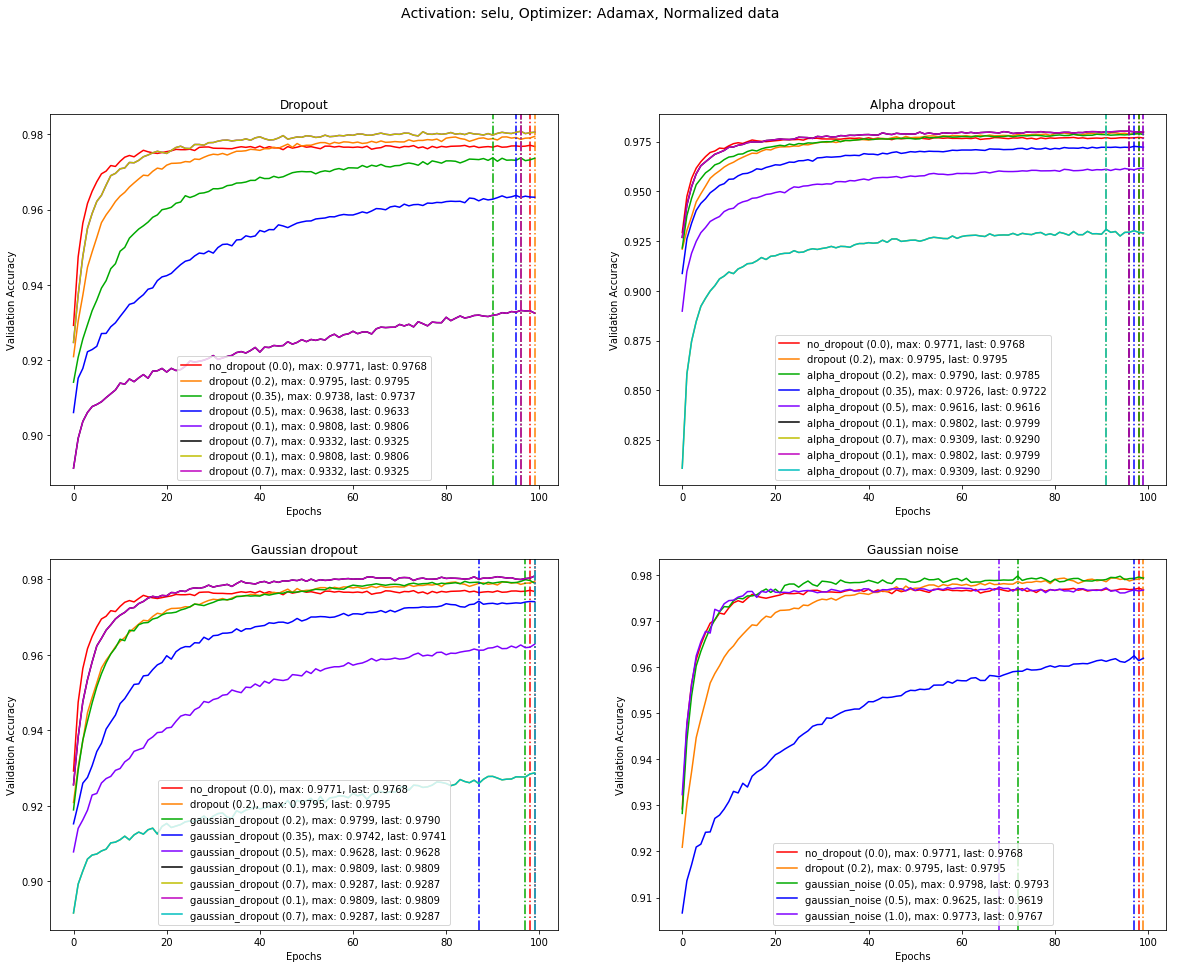

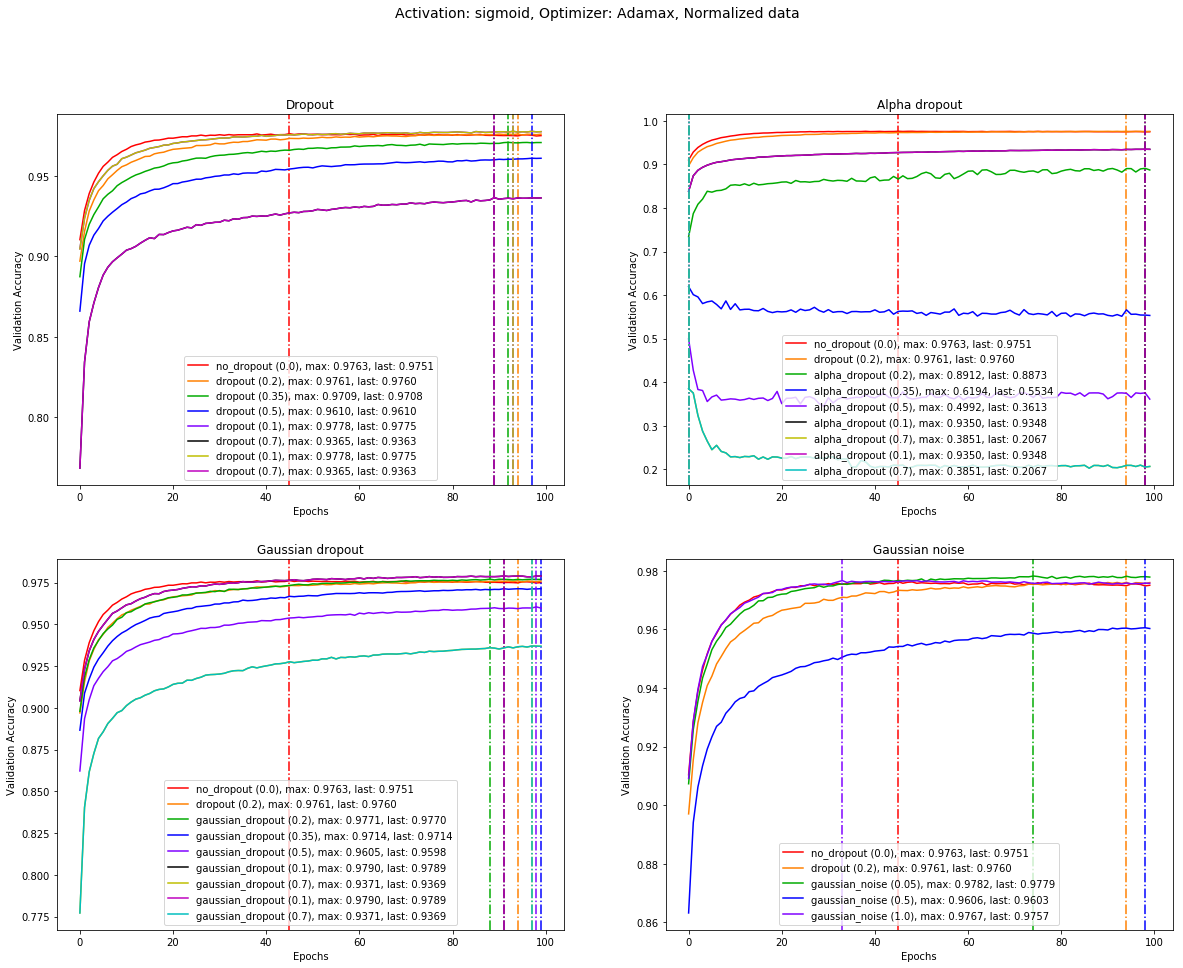

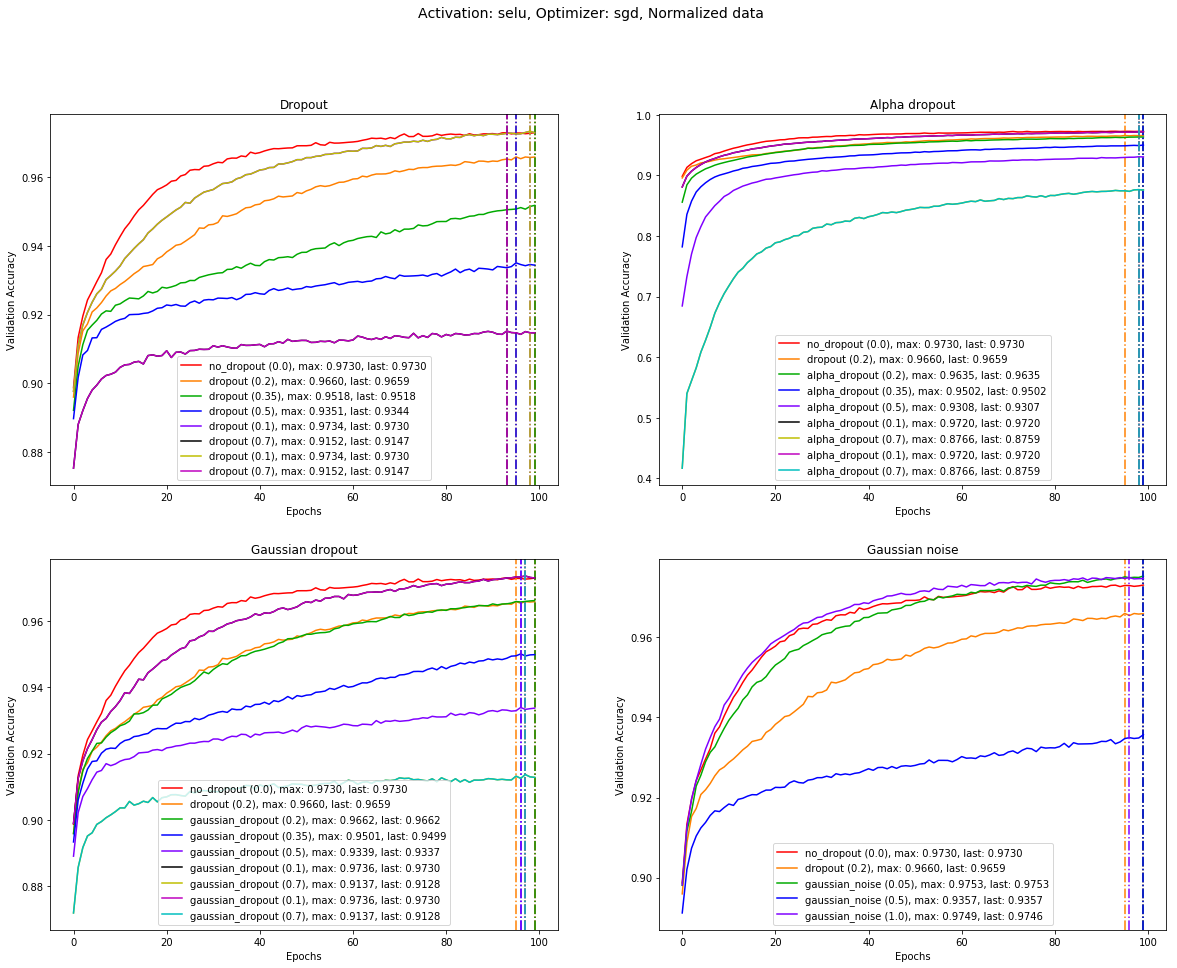

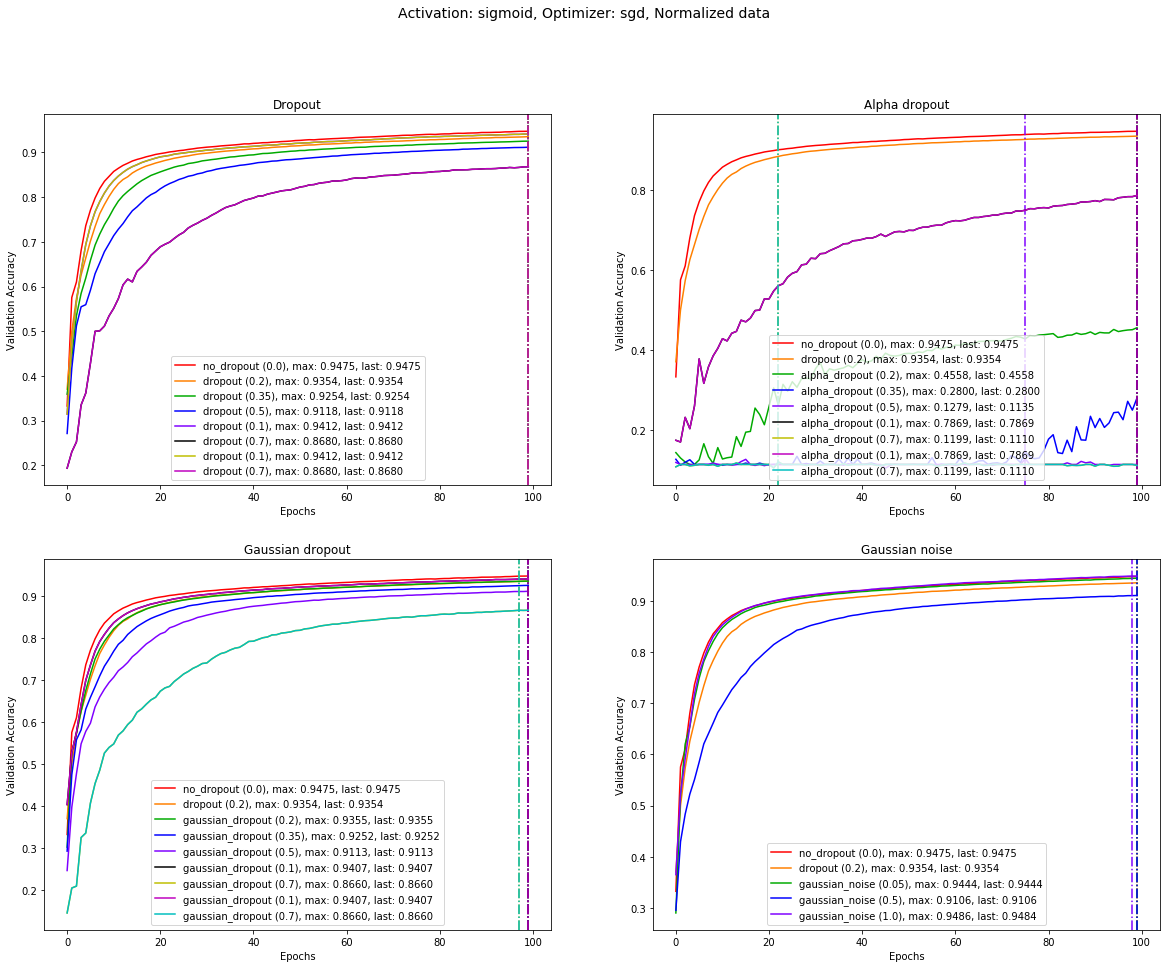

In [20]:
for opt in optimizers:
    for act in activations:
                    
        plt.figure(figsize=(20,15))
        plt.suptitle('Activation: %s, Optimizer: %s, Normalized data' % (act, opt), fontsize=14)
        plt.subplot(2,2,1)
        plt.title('Dropout')
        clr = 0

        for d in range(len(data_normd)):
            if act == data_normd[d]['act'] and opt == data_normd[d]['opt'] \
                and (data_normd[d]['type'] == 'no_dropout' or data_normd[d]['type'] == 'dropout'):

                plt.plot(range(epochs),
                             data_normd[d]['averaged']['val_acc'].tolist(),
                             colors_new[clr],
                             linestyle='-',
                             label=data_normd[d]['drp_cfg'] + ', max: %0.4f, last: %0.4f' % (data_normd[d]['max_val_acc']['avg']['val_acc'], data_normd[d]['averaged']['val_acc'].tolist()[-1]))
                
                plt.axvline(x=data_normd[d]['max_val_acc']['avg']['epoch'],
                            color = colors_new[clr],                   
                            linestyle='-.')
                
                clr+=1

        plt.legend(loc='lower center',ncol=1)
        plt.xlabel('Epochs')
        plt.ylabel('Validation Accuracy')
        
        clr = 0
        plt.subplot(2,2,2)
        plt.title('Alpha dropout')

        for d in range(len(data_normd)):
            if act == data_normd[d]['act'] and opt == data_normd[d]['opt'] \
                and (data_normd[d]['type'] == 'no_dropout' \
                     or (data_normd[d]['type'] == 'dropout' and data_normd[d]['rate'] == 0.2) \
                     or data_normd[d]['type'] == 'alpha_dropout'):

                plt.plot(range(epochs),
                             data_normd[d]['averaged']['val_acc'].tolist(),
                             colors_new[clr],
                             linestyle='-',
                             label=data_normd[d]['drp_cfg'] + ', max: %0.4f, last: %0.4f' % (data_normd[d]['max_val_acc']['avg']['val_acc'], data_normd[d]['averaged']['val_acc'].tolist()[-1])) 
                
                plt.axvline(x=data_normd[d]['max_val_acc']['avg']['epoch'], 
                            color = colors_new[clr],                   
                            linestyle='-.')
                
                clr+=1
                
        plt.legend(loc='lower center',ncol=1)
        plt.xlabel('Epochs')
        plt.ylabel('Validation Accuracy')
        
        clr = 0
        plt.subplot(2,2,3)
        plt.title('Gaussian dropout')

        for d in range(len(data_normd)):
            if act == data_normd[d]['act'] and opt == data_normd[d]['opt'] \
                and (data_normd[d]['type'] == 'no_dropout' \
                     or (data_normd[d]['type'] == 'dropout' and data_normd[d]['rate'] == 0.2) \
                     or data_normd[d]['type'] == 'gaussian_dropout'):

                plt.plot(range(epochs),
                             data_normd[d]['averaged']['val_acc'].tolist(),
                             colors_new[clr],
                             linestyle='-',
                             label=data_normd[d]['drp_cfg'] + ', max: %0.4f, last: %0.4f' % (data_normd[d]['max_val_acc']['avg']['val_acc'], data_normd[d]['averaged']['val_acc'].tolist()[-1])) 
                
                plt.axvline(x=data_normd[d]['max_val_acc']['avg']['epoch'], 
                            color = colors_new[clr],                   
                            linestyle='-.')
                
                clr+=1
                
        plt.legend(loc='lower center',ncol=1)
        plt.xlabel('Epochs')
        plt.ylabel('Validation Accuracy')
        
        clr = 0
        plt.subplot(2,2,4)
        plt.title('Gaussian noise')

        for d in range(len(data_normd)):
            if act == data_normd[d]['act'] and opt == data_normd[d]['opt'] \
                and (data_normd[d]['type'] == 'no_dropout' \
                     or (data_normd[d]['type'] == 'dropout' and data_normd[d]['rate'] == 0.2) \
                     or data_normd[d]['type'] == 'gaussian_noise'):

                plt.plot(range(epochs),
                             data_normd[d]['averaged']['val_acc'].tolist(),
                             colors_new[clr],
                             linestyle='-',
                             label=data_normd[d]['drp_cfg'] + ', max: %0.4f, last: %0.4f' % (data_normd[d]['max_val_acc']['avg']['val_acc'], data_normd[d]['averaged']['val_acc'].tolist()[-1])) 
                
                plt.axvline(x=data_normd[d]['max_val_acc']['avg']['epoch'], 
                            color = colors_new[clr],                   
                            linestyle='-.')
                
                clr+=1
                
        plt.legend(loc='lower center',ncol=1)
        plt.xlabel('Epochs')
        plt.ylabel('Validation Accuracy')

        plt.show()

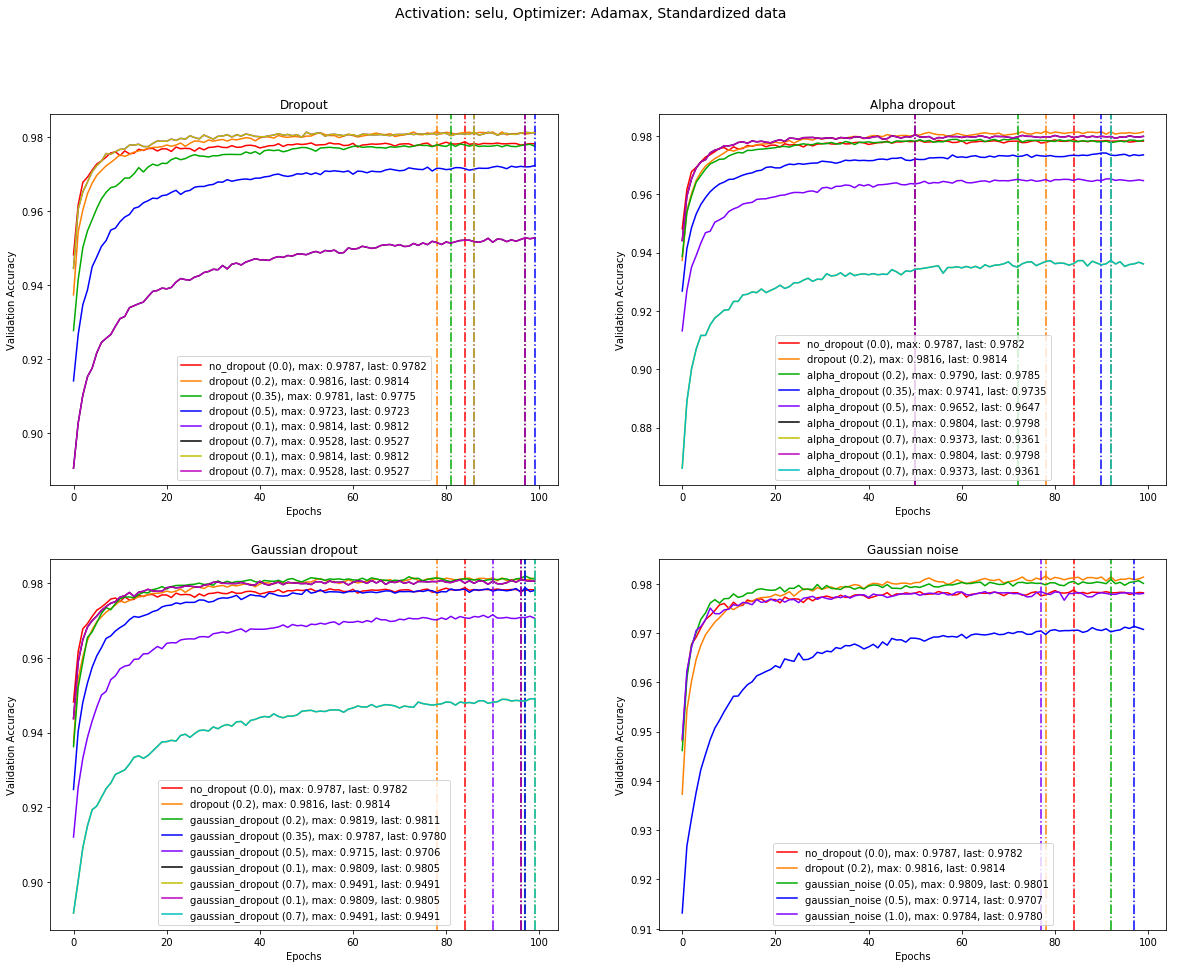

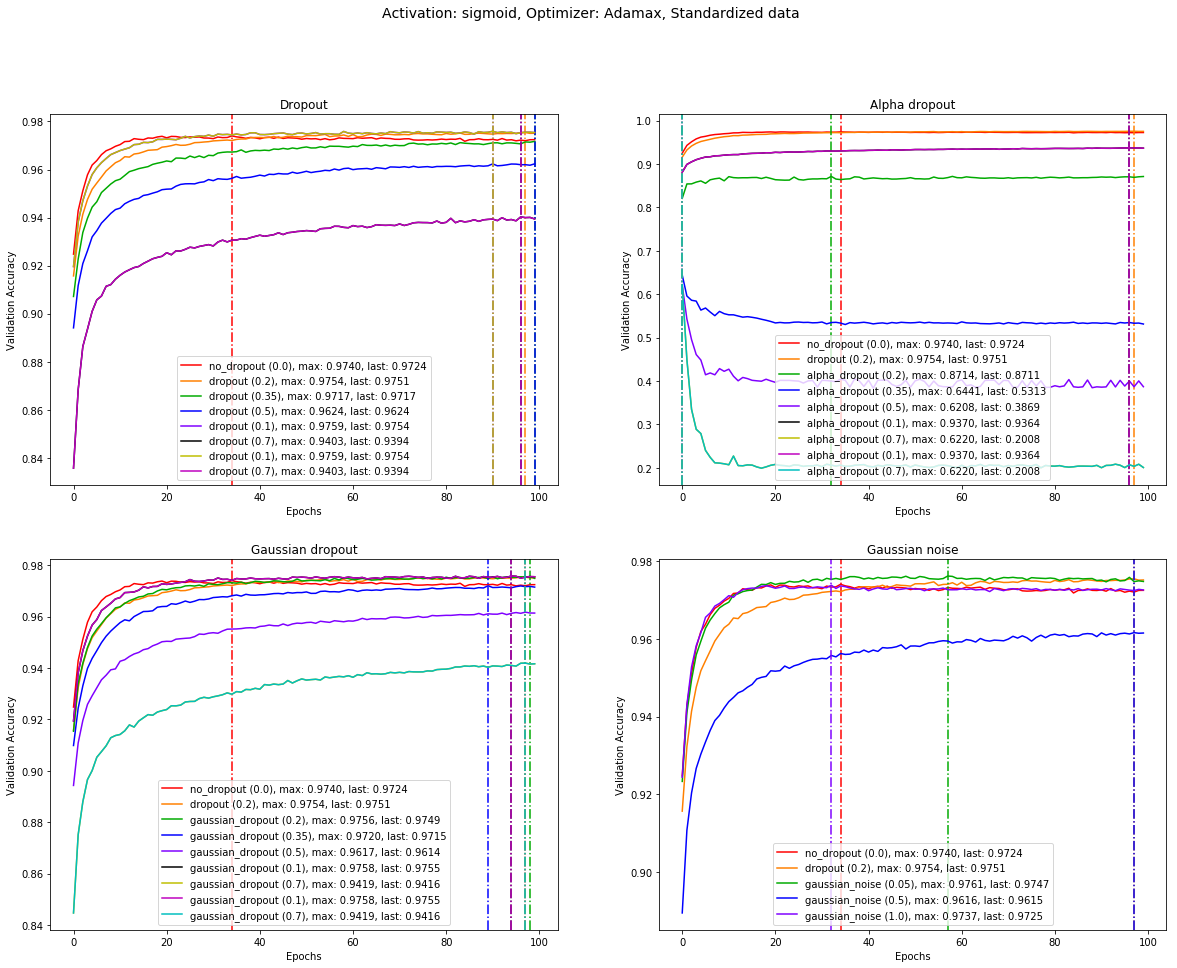

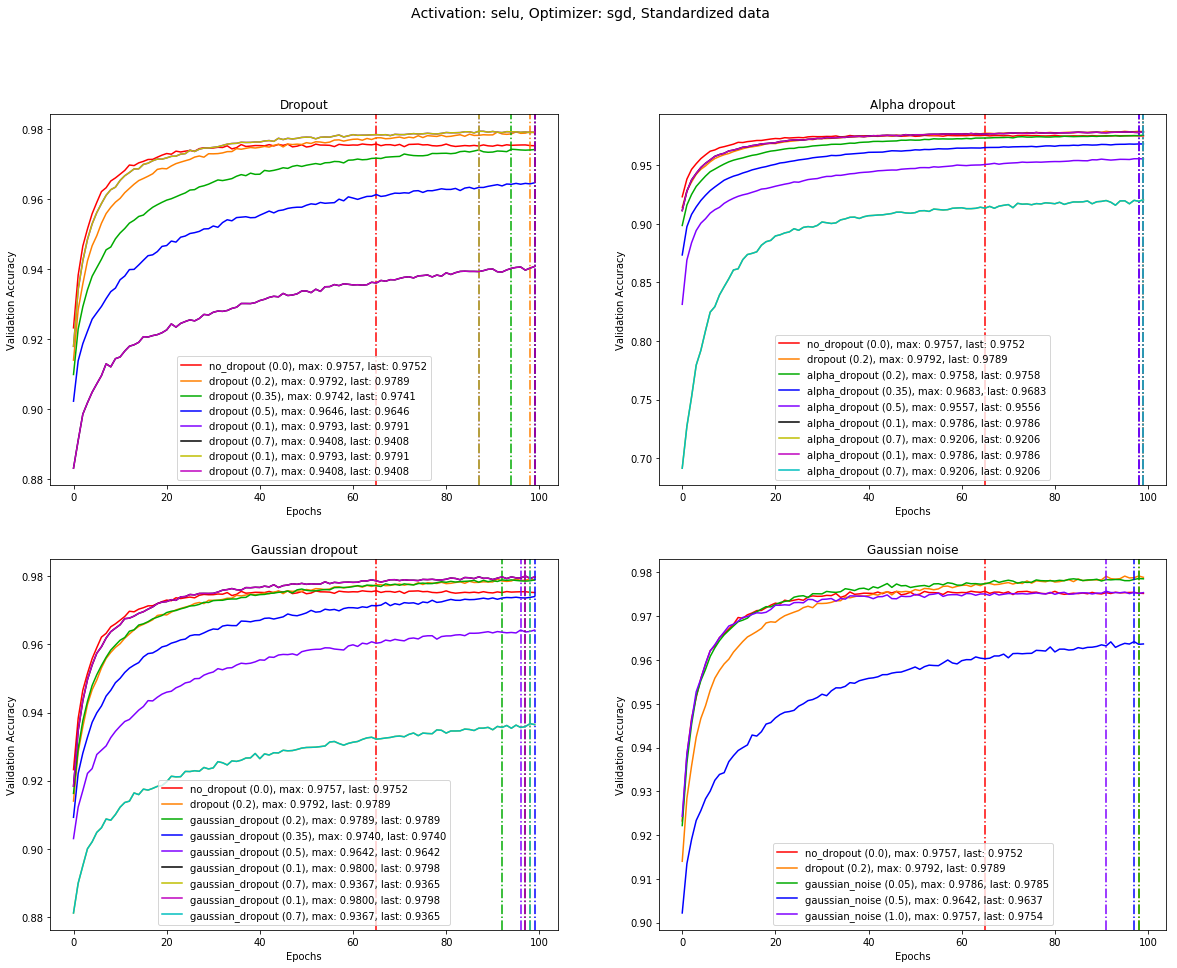

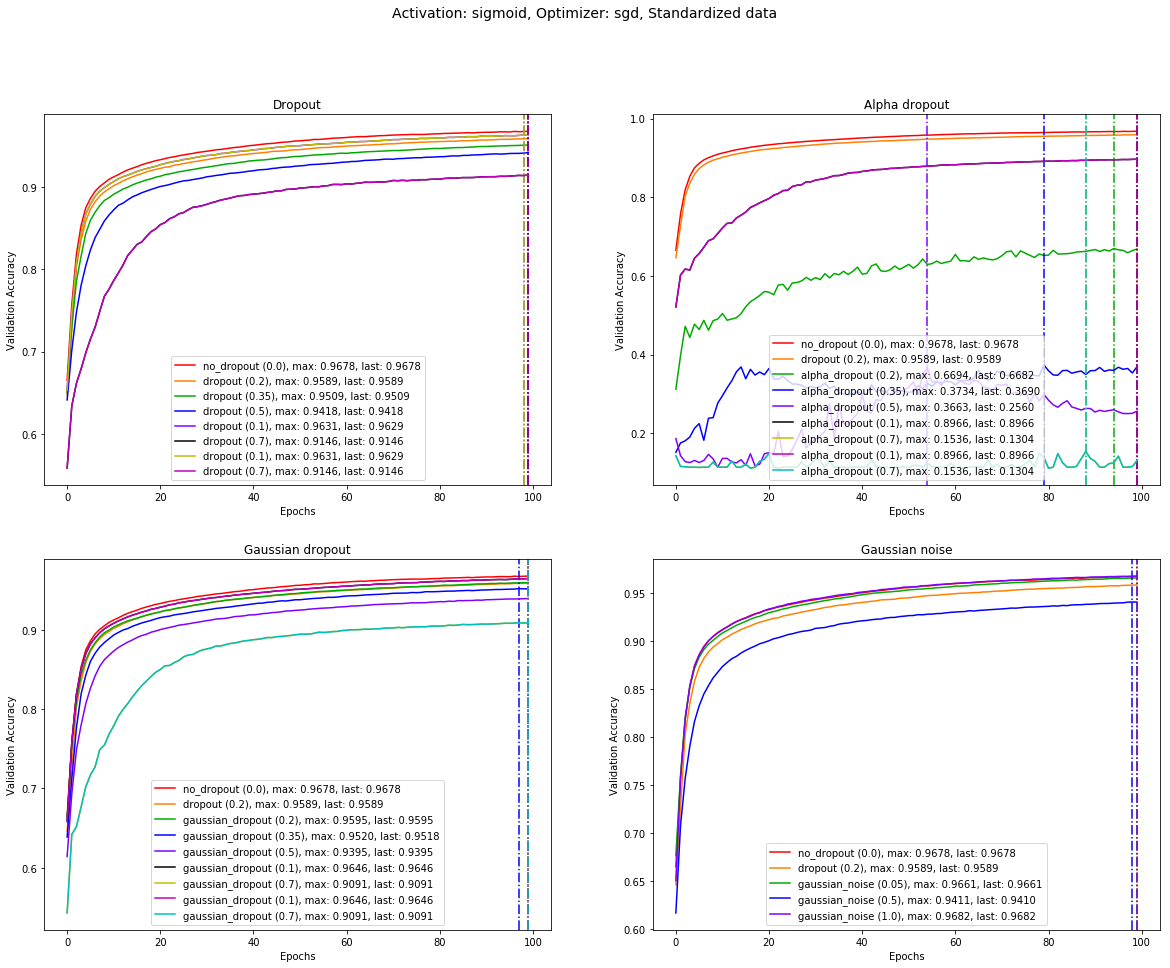

In [22]:
for opt in optimizers:
    for act in activations:
                    
        plt.figure(figsize=(20,15))
        plt.suptitle('Activation: %s, Optimizer: %s, Standardized data' % (act, opt), fontsize=14)
        plt.subplot(2,2,1)
        plt.title('Dropout')
        clr = 0

        for d in range(len(data_std)):
            if act == data_std[d]['act'] and opt == data_std[d]['opt'] \
                and (data_std[d]['type'] == 'no_dropout' or data_std[d]['type'] == 'dropout'):

                plt.plot(range(epochs),
                             data_std[d]['averaged']['val_acc'].tolist(),
                             colors_new[clr],
                             linestyle='-',
                             label=data_std[d]['drp_cfg'] + ', max: %0.4f, last: %0.4f' % (data_std[d]['max_val_acc']['avg']['val_acc'], data_std[d]['averaged']['val_acc'].tolist()[-1]))
                
                plt.axvline(x=data_std[d]['max_val_acc']['avg']['epoch'],
                            color = colors_new[clr],                   
                            linestyle='-.')
                
                clr+=1

        plt.legend(loc='lower center',ncol=1)
        plt.xlabel('Epochs')
        plt.ylabel('Validation Accuracy')
        
        clr = 0
        plt.subplot(2,2,2)
        plt.title('Alpha dropout')

        for d in range(len(data_std)):
            if act == data_std[d]['act'] and opt == data_std[d]['opt'] \
                and (data_std[d]['type'] == 'no_dropout' \
                     or (data_std[d]['type'] == 'dropout' and data_std[d]['rate'] == 0.2) \
                     or data_std[d]['type'] == 'alpha_dropout'):

                plt.plot(range(epochs),
                             data_std[d]['averaged']['val_acc'].tolist(),
                             colors_new[clr],
                             linestyle='-',
                             label=data_std[d]['drp_cfg'] + ', max: %0.4f, last: %0.4f' % (data_std[d]['max_val_acc']['avg']['val_acc'], data_std[d]['averaged']['val_acc'].tolist()[-1])) 
                
                plt.axvline(x=data_std[d]['max_val_acc']['avg']['epoch'], 
                            color = colors_new[clr],                   
                            linestyle='-.')
                
                clr+=1
                
        plt.legend(loc='lower center',ncol=1)
        plt.xlabel('Epochs')
        plt.ylabel('Validation Accuracy')
        
        clr = 0
        plt.subplot(2,2,3)
        plt.title('Gaussian dropout')

        for d in range(len(data_std)):
            if act == data_std[d]['act'] and opt == data_std[d]['opt'] \
                and (data_std[d]['type'] == 'no_dropout' \
                     or (data_std[d]['type'] == 'dropout' and data_std[d]['rate'] == 0.2) \
                     or data_std[d]['type'] == 'gaussian_dropout'):

                plt.plot(range(epochs),
                             data_std[d]['averaged']['val_acc'].tolist(),
                             colors_new[clr],
                             linestyle='-',
                             label=data_std[d]['drp_cfg'] + ', max: %0.4f, last: %0.4f' % (data_std[d]['max_val_acc']['avg']['val_acc'], data_std[d]['averaged']['val_acc'].tolist()[-1])) 
                
                plt.axvline(x=data_std[d]['max_val_acc']['avg']['epoch'], 
                            color = colors_new[clr],                   
                            linestyle='-.')
                
                clr+=1
                
        plt.legend(loc='lower center',ncol=1)
        plt.xlabel('Epochs')
        plt.ylabel('Validation Accuracy')
        
        clr = 0
        plt.subplot(2,2,4)
        plt.title('Gaussian noise')

        for d in range(len(data_std)):
            if act == data_std[d]['act'] and opt == data_std[d]['opt'] \
                and (data_std[d]['type'] == 'no_dropout' \
                     or (data_std[d]['type'] == 'dropout' and data_std[d]['rate'] == 0.2) \
                     or data_std[d]['type'] == 'gaussian_noise'):

                plt.plot(range(epochs),
                             data_std[d]['averaged']['val_acc'].tolist(),
                             colors_new[clr],
                             linestyle='-',
                             label=data_std[d]['drp_cfg'] + ', max: %0.4f, last: %0.4f' % (data_std[d]['max_val_acc']['avg']['val_acc'], data_std[d]['averaged']['val_acc'].tolist()[-1])) 
                
                plt.axvline(x=data_std[d]['max_val_acc']['avg']['epoch'], 
                            color = colors_new[clr],                   
                            linestyle='-.')
                
                clr+=1
                
        plt.legend(loc='lower center',ncol=1)
        plt.xlabel('Epochs')
        plt.ylabel('Validation Accuracy')

        plt.show()